In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load CSV files containing the labels
train_classes_df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/colorpalette/data/train/_classes.csv')
valid_classes_df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/colorpalette/data/valid/_classes.csv')
test_classes_df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/colorpalette/data/test/_classes.csv')

In [4]:
# Directory paths
train_dir = '/content/drive/MyDrive/ColabNotebooks/colorpalette/data/train'
valid_dir = '/content/drive/MyDrive/ColabNotebooks/colorpalette/data/valid'
test_dir = '/content/drive/MyDrive/ColabNotebooks/colorpalette/data/test'


# Image and batch parameters
img_height, img_width = 224, 224
batch_size = 32

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_classes_df,
    directory=train_dir,
    x_col="filename",
    y_col=[" fall", " spring", " summer", " winter"],
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="raw"
)

# Validation data generator
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_classes_df,
    directory=valid_dir,
    x_col="filename",
    y_col=[" fall", " spring", " summer", " winter"],
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="raw"
)

Found 456 validated image filenames.
Found 50 validated image filenames.


In [21]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze earlier layers of the pretrained model
for layer in base_model.layers[:-70]:
    layer.trainable = False

In [27]:
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])

In [44]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,591,406 (177.73 MB)

 Trainable params: 12,262,916 (46.78 MB)

 Non-trainable params: 9,802,656 (37.39 MB)

 Optimizer params: 24,525,834 (93.56 MB)

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [30]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 115s 7s/step - accuracy: 0.3332 - loss: 1.4057 - val_accuracy: 0.2812 - val_loss: 1.4270
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.3125 - loss: 1.2308 - val_accuracy: 0.3889 - val_loss: 1.5031
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 127s 6s/step - accuracy: 0.3803 - loss: 1.2431
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5625 - loss: 1.1373 - val_accuracy: 0.4062 - val_loss: 1.4626
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 129s 6s/step - accuracy: 0.4923 - loss: 1.1316 - val_accuracy: 0.5000 - val_loss: 1.0522
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5625 - loss: 1.0814 
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 96s 7s/step - accuracy: 0.6280 - loss: 0.9618 - val_accuracy: 0.6250 - val_loss: 1.2156
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.6250 - loss: 0.9757 - val_accuracy: 0.6111 - val_loss: 1.4199
Epoch 9/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.

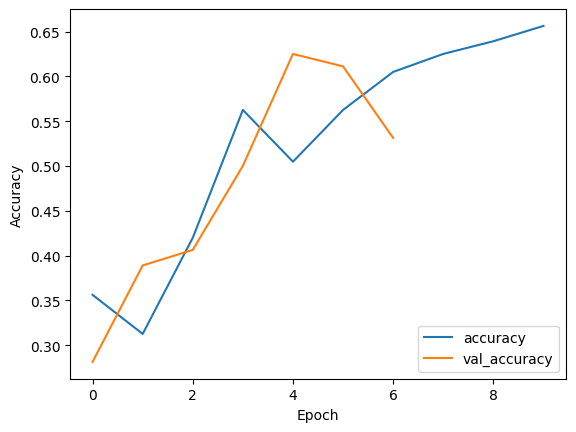

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [55]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

for filename in os.listdir(test_dir):
    file_path = os.path.join(test_dir, filename)
    if os.path.isfile(file_path):
        try:
            img = load_img(file_path, target_size=(img_height, img_width))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # Predict
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=-1)

            class_labels = ["fall", "spring", "summer", "winter"]
            predicted_label = class_labels[predicted_class[0]]

            # Output the prediction
            print(f"Filename: {filename}")
            print(f"Predicted Class: {predicted_label}")

        except Exception as e:
            print(f"Error processing file {filename}: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Filename: img20_jpg.rf.ff7d3fe12d9bec7af311442707e1970c.jpg
Predicted Class: spring
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Filename: img102_jpg.rf.1b1d991caf3477e50fdc6970605aa8d4.jpg
Predicted Class: spring
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Filename: img25_jpg.rf.0746004515397329b440bf1682d03f37.jpg
Predicted Class: spring
Error processing file _classes.csv: cannot identify image file <_io.BytesIO object at 0x7ef23029ccc0>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Filename: img105_jpg.rf.5451f1fa31f75790f69e7692508f9a86.jpg
Predicted Class: spring
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
Filename: img23_jpg.rf.58cb70b240373e72816362d09eeb6ab2.jpg
Predicted Class: fall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Filename: img26_jpg.rf.377f2b0690067c82d4d6f7fc3edbb57d.jpg
Predicted Class: spring
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Filename: img11_jpg.rf.0cd0254e86b7f84aa71913ae001eca67.jpg
Predicted Class: fall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


In [42]:
model.save('model.h5')

In [43]:
# Save the model in TFLite format
tflite_model_path = "model.tflite"

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved at {tflite_model_path}")

Saved artifact at '/tmp/tmpogb7441q'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_640')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139578707728464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139578784331584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139578707727936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139578842695456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139578806343584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139578831352608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139578707840688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139578784326304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139578831348912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139578762664368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1395787626